In [1]:
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn import pipeline

from datetime import datetime
import time

# 1. Loading the Data
    - listings.csv.gz | has all the information for a given listing

In [2]:
listingsGZ_df = pd.read_csv('Denver AirBnB/listings.csv.gz', compression='gzip',
                   error_bad_lines=False)

# 2) Data Wrangling

#### 2.1) Selecting Desired Features

In [3]:
model_cols = [
       'price', 'id', 'latitude', 'longitude', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
        'availability_365', 'instant_bookable', 'neighbourhood'
        ]

In [4]:
master_df = listingsGZ_df[model_cols]

#### 2.2) Changing price data type

In [5]:
master_df['price'] = master_df['price'].str.replace('$', '')
master_df['price'] = master_df['price'].str.replace(',', '').astype(float)
master_df['price'] = master_df['price'].astype(float)

<ipython-input-5-31814f604166>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['price'] = master_df['price'].str.replace('$', '')
<ipython-input-5-31814f604166>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['price'] = master_df['price'].str.replace(',', '').astype(float)
<ipython-input-5-31814f604166>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

#### 2.3) Feature Engeneering shared_bathroom | Changing bathroom_qty to integers

In [6]:
master_df['shared_bathroom'] = master_df['bathrooms_text'].str.contains('shared', case=False)
master_df['shared_bathroom'].loc[master_df['shared_bathroom'] == True] = 1
master_df['shared_bathroom'].loc[master_df['shared_bathroom'] == False] = 0
master_df = master_df.dropna(axis=0, subset=['shared_bathroom']).reset_index(drop=True)
master_df['shared_bathroom'] = master_df['shared_bathroom'].astype(int)

master_df['bathrooms_text'] = master_df['bathrooms_text'].str.replace('Half-bath','.5')
master_df['bathrooms_text'] = master_df['bathrooms_text'].str.replace('Shared half-bath','.5')
master_df['bathrooms_text'] = master_df['bathrooms_text'].str.replace(r'[aA-zZ]+','')
master_df['bathrooms_text'] = master_df['bathrooms_text'].str.replace(' ','')
master_df['bathrooms_text'] = master_df['bathrooms_text'].astype(float)

master_df.rename(columns = {'bathrooms_text' : 'bathroom_qty'}, inplace=True)

<ipython-input-6-ae999e1c9e58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['shared_bathroom'] = master_df['bathrooms_text'].str.contains('shared', case=False)
C:\Users\Trey\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-6-ae999e1c9e58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [7]:
master_df['instant_bookable'].loc[master_df['instant_bookable'] == 't'] = 1
master_df['instant_bookable'].loc[master_df['instant_bookable'] == 'f'] = 0
master_df['instant_bookable'] = master_df['instant_bookable'].astype(int)

C:\Users\Trey\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### 2.7) Categorical Variables: 'property_type', 'host_response_time', 'room_type', 'neighbourhood'

In [8]:
categ_cols = ['room_type', 'neighbourhood']

master_df['neighbourhood'].fillna(master_df['neighbourhood'].mode()[0], inplace=True )

for categ_col in categ_cols:
    master_df[categ_col+"_encoded"] = master_df[categ_col].astype('category').cat.codes
    master_df.drop(columns=categ_col, inplace=True)

#### 2.8) NA Values

In [9]:
master_df[['beds', 'bedrooms']] = master_df[['beds', 'bedrooms']].apply(lambda x: x.fillna( x.mean() ), axis=0)

# 3) EDA

#### Summary:
    Noticed dropping outliars changed the correlations between IVs and DV. 

In [10]:
"""Plots the distribution and percentage of occurances for each value that occures more than 1% of the time"""
def plot_distibution(column, df=master_df):
    plt.figure(figsize=(20,6))
    fig = sns.histplot(x=df[column], kde=True)
    plt.title("Distribution of: "+column, fontsize=20);
    
    value_counts = df[column].value_counts(dropna=True, sort=True)
    df_val_counts = pd.DataFrame(value_counts)
    df_value_counts_reset = df_val_counts.reset_index()
    df_value_counts_reset.columns = [column, 'Count']
    df_value_counts_reset['Count Percent'] = df_value_counts_reset['Count'] /len(df)
    return df_value_counts_reset.loc[df_value_counts_reset['Count Percent'] > 0.01]

### 3.1) Response Variable: price
#### Summary
 - Removed outliars and then removed rows that did not have a given amount on reviews (19). This removed a lot of the right skew and helped get the data closer to a normal distrobution.

,price,Count,Count Percent
0,99.0,77,0.020031
1,100.0,64,0.016649
2,150.0,61,0.015869
3,125.0,59,0.015349
4,75.0,57,0.014828
5,80.0,47,0.012227
6,65.0,44,0.011446
7,135.0,43,0.011186
8,120.0,43,0.011186
9,200.0,43,0.011186


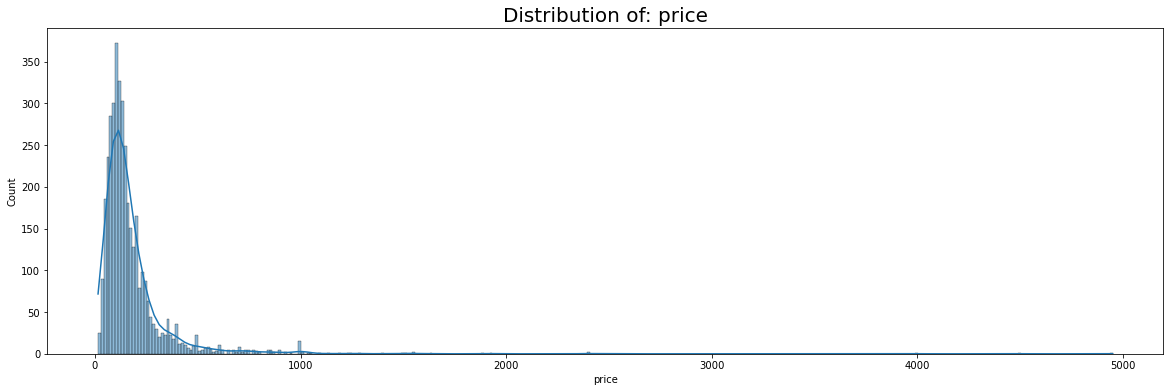

In [11]:
plot_distibution('price')

## 3.2) Investigating Highest Correlations

In [12]:
master_df.corr()

,price,id,latitude,longitude,accommodates,bathroom_qty,bedrooms,beds,minimum_nights,maximum_nights,availability_365,instant_bookable,shared_bathroom,room_type_encoded,neighbourhood_encoded
price,1.000000,0.044217,0.036020,-0.079254,0.456714,0.499953,0.476401,0.497698,-0.030940,0.015983,0.028917,-0.002228,-0.136992,-0.162394,-0.007739
id,0.044217,1.000000,-0.017623,0.005146,0.006433,0.024439,-0.012236,-0.007105,-0.016094,-0.047070,0.104763,0.234291,-0.042419,-0.066594,-0.021421
latitude,0.036020,-0.017623,1.000000,0.058601,0.065077,0.050795,0.023450,0.042026,-0.034871,0.031149,-0.022917,0.013713,-0.057285,-0.059397,-0.015210
longitude,-0.079254,0.005146,0.058601,1.000000,-0.036532,0.012642,-0.010611,-0.020004,0.093250,0.020313,0.060834,-0.017495,0.163625,0.244166,-0.110084
accommodates,0.456714,0.006433,0.065077,-0.036532,1.000000,0.624488,0.809731,0.723574,-0.110699,-0.007954,0.015006,0.021770,-0.221752,-0.307331,0.002486
bathroom_qty,0.499953,0.024439,0.050795,0.012642,0.624488,1.000000,0.708488,0.615360,-0.027424,0.010566,0.006366,-0.016057,-0.053823,-0.130114,-0.010963
bedrooms,0.476401,-0.012236,0.023450,-0.010611,0.809731,0.708488,1.000000,0.733158,-0.065061,0.021056,-0.026831,-0.026130,-0.195991,-0.287656,0.024369
beds,0.497698,-0.007105,0.042026,-0.020004,0.723574,0.615360,0.733158,1.000000,-0.074455,0.008330,0.007380,0.003430,-0.125904,-0.181405,0.013430
minimum_nights,-0.030940,-0.016094,-0.034871,0.093250,-0.110699,-0.027424,-0.065061,-0.074455,1.000000,0.176868,0.185588,-0.026931,0.018265,-0.010137,-0.012145
maximum_nights,0.015983,-0.047070,0.031149,0.020313,-0.007954,0.010566,0.021056,0.008330,0.176868,1.000000,0.100056,-0.004238,-0.040486,-0.049974,-0.051574


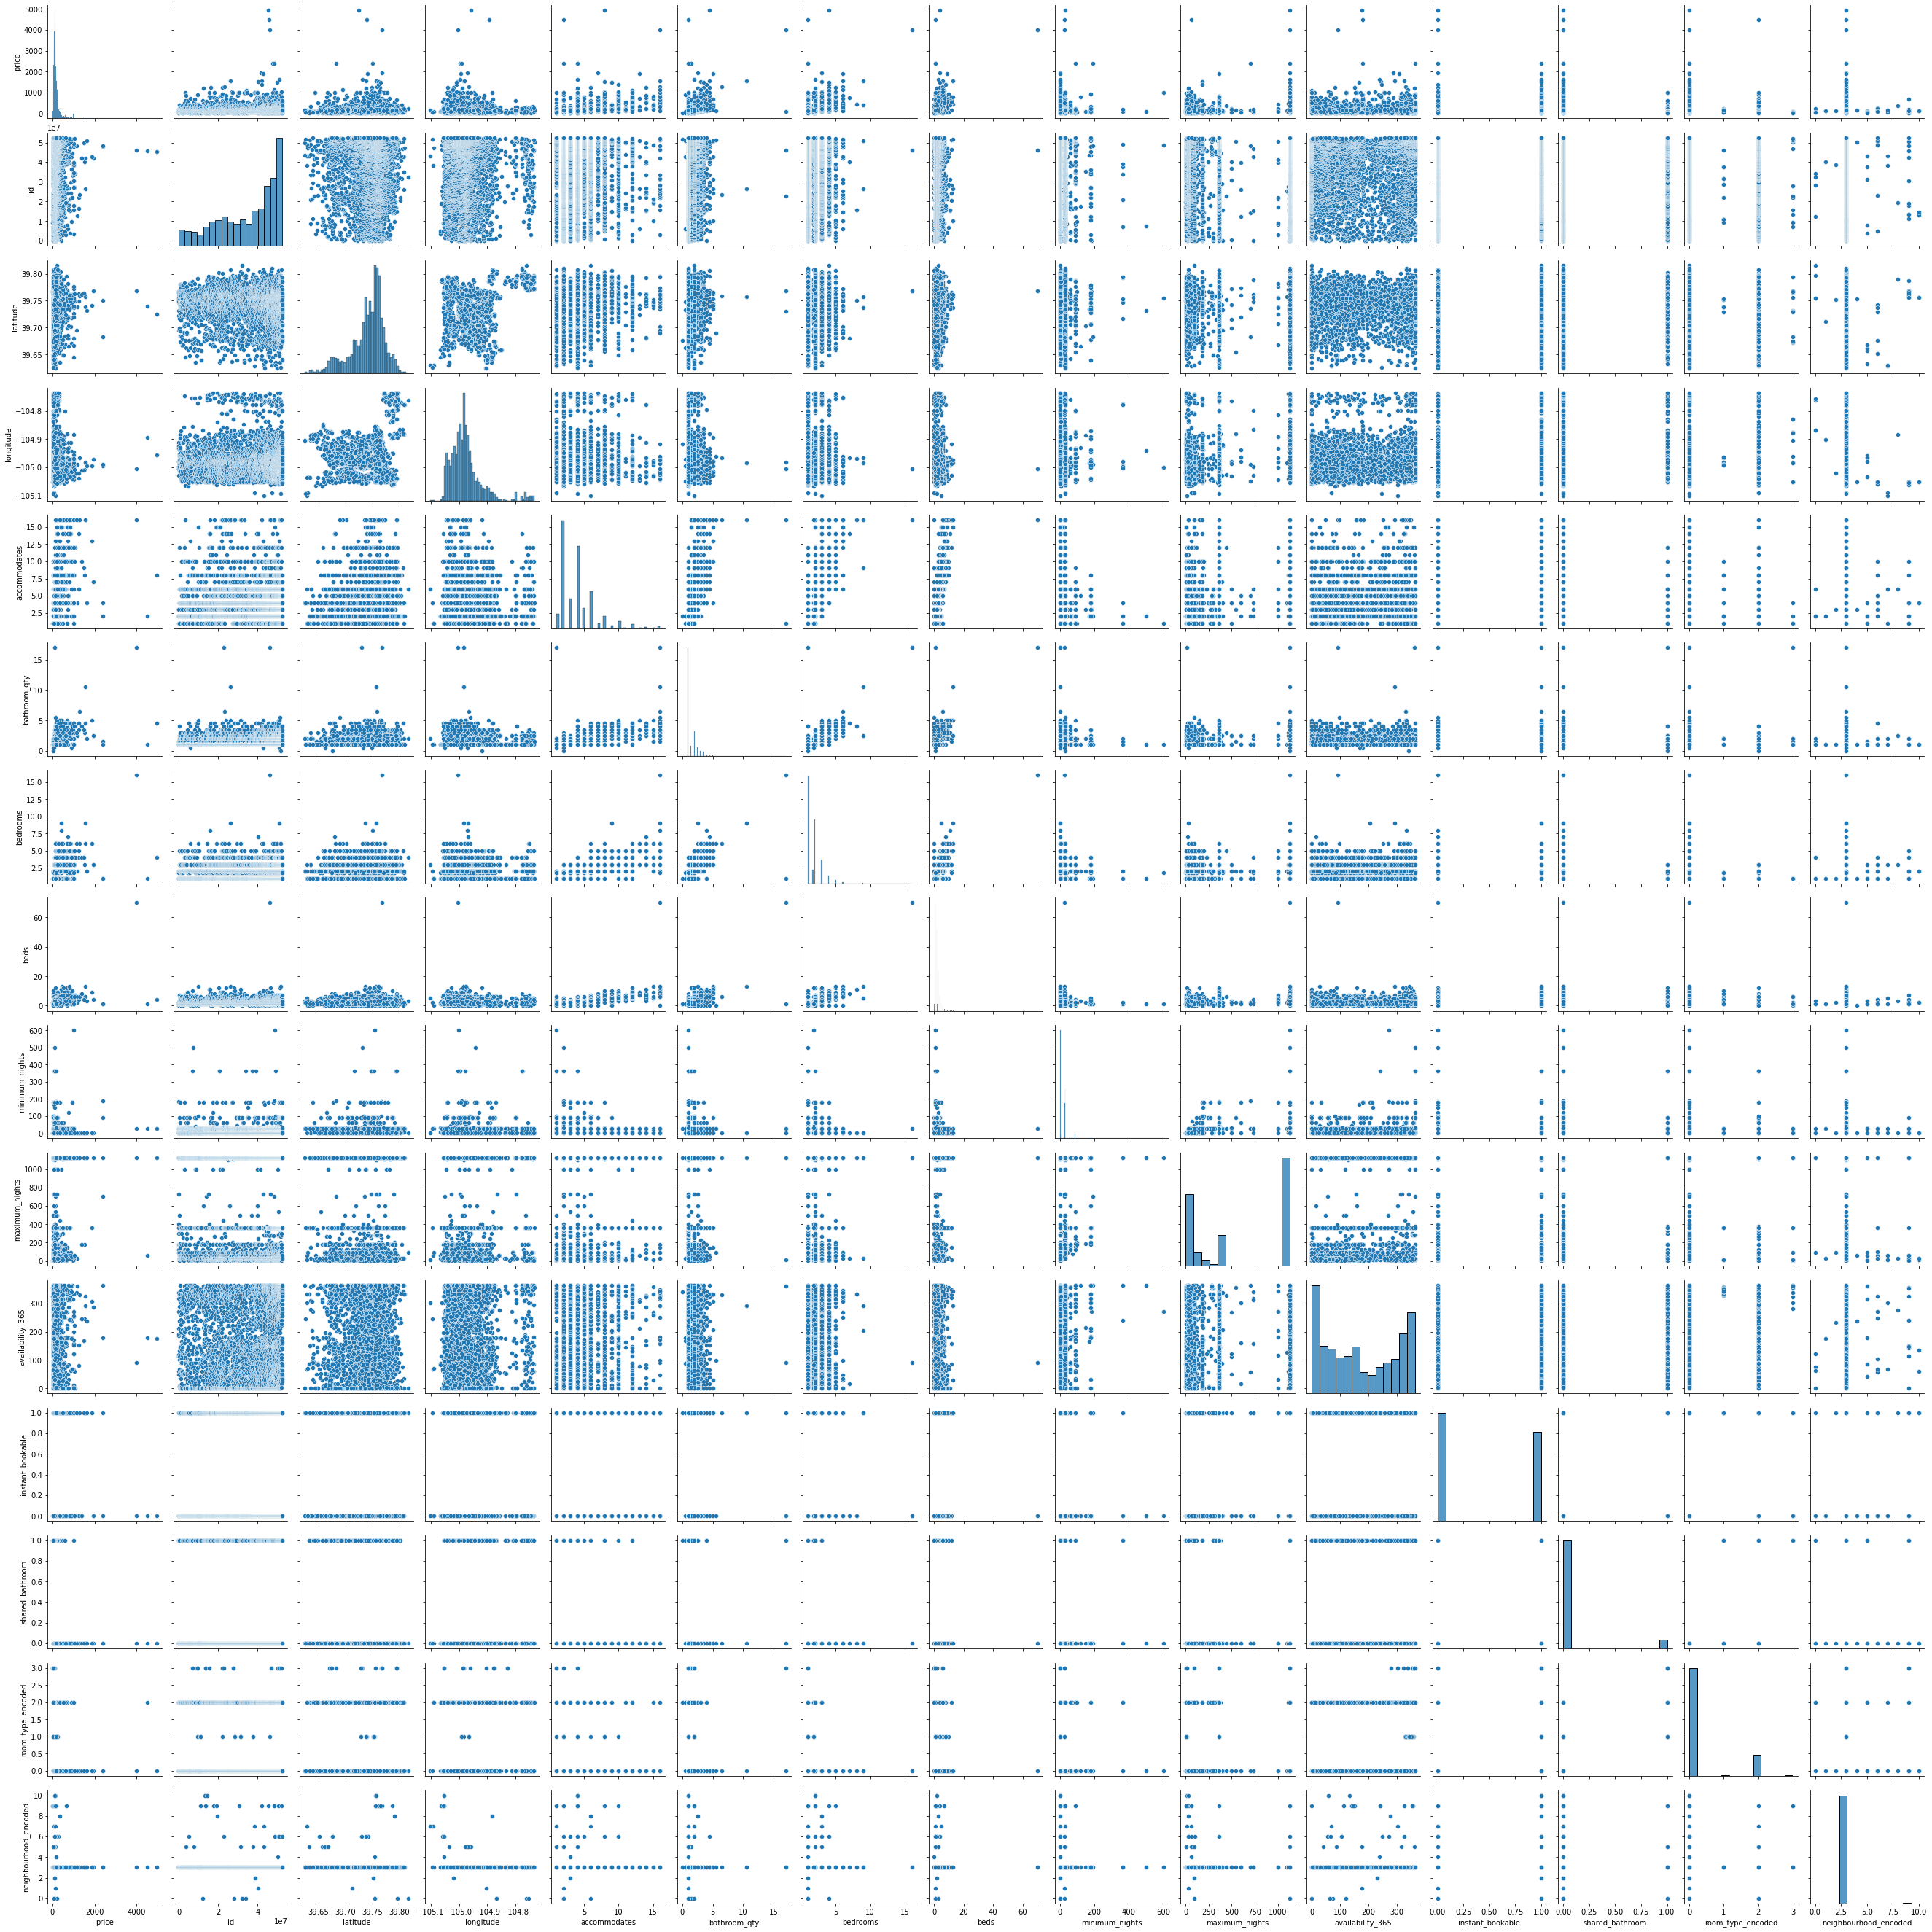

In [13]:
sns.pairplot(master_df)

In [14]:
master_df.columns

Index(['price', 'id', 'latitude', 'longitude', 'accommodates', 'bathroom_qty',
       'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'availability_365', 'instant_bookable', 'shared_bathroom',
       'room_type_encoded', 'neighbourhood_encoded'],
      dtype='object')

# 4) Modeling
    
    Initially I performed a multiple linear reggression and tried to optimize the parameters by selecting the minimal number of features for the model. However, further research and feedback lead to trying multiple models and cross validating them.

In [15]:
import re
model_df = master_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
model_df.drop(columns='id', inplace=True)

X = model_df.copy().drop('price', axis = 1)
y = model_df['price'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Machine Learning

In [17]:
lr = LinearRegression()
alphas = [1000, 100, 50, 20, 10, 1, 0.1, 0.01]
l1_ratios = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
ridge = RidgeCV(alphas=alphas)
lasso = LassoCV(alphas=alphas, max_iter=50000, tol=.001)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)

In [18]:
for model, name in zip([lr, ridge, lasso, elastic], ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']):
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    mrse_train = np.sqrt(mean_squared_error(y_pred=y_pred_train, y_true=y_train))
    y_pred = model.predict(X_test_scaled)
    mrse_test = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
    best_alpha = ''
    if name != 'LinearRegression':
        best_alpha = ' best alpha: ' + str(model.alpha_)
    best_l1 = ''
    if name == 'ElasticNet':
        best_l1 = ' best l1: '+ str(model.l1_ratio_)
    print(name + ' mrse_train: ' + str(mrse_train) + ', mrse_test: ' + str(mrse_test) + best_alpha + best_l1)
    print('score:', model.score(X_test_scaled, y_test))

LinearRegression mrse_train: 154.61743505020135, mrse_test: 215.92713147504807
score: 0.30721672689502977
Ridge mrse_train: 155.25381826266505, mrse_test: 215.00014431388112 best alpha: 1000.0
score: 0.31315227276703905
Lasso mrse_train: 154.64521614268477, mrse_test: 216.40695005049886 best alpha: 1.0
score: 0.30413439434443545
ElasticNet mrse_train: 154.77744186567784, mrse_test: 214.87750392000424 best alpha: 1.0 best l1: 0.9
score: 0.3139356327161661


# LGBM Regressor

#### Untuned

In [19]:
untuned_gbm = lgb.LGBMRegressor()
untuned_gbm.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_test, y_test)])

[1]	valid_0's rmse: 254.997	valid_0's l2: 65023.5
[2]	valid_0's rmse: 250.517	valid_0's l2: 62758.7
[3]	valid_0's rmse: 246.736	valid_0's l2: 60878.5
[4]	valid_0's rmse: 243.581	valid_0's l2: 59331.6
[5]	valid_0's rmse: 240.682	valid_0's l2: 57927.9
[6]	valid_0's rmse: 238.435	valid_0's l2: 56851.2
[7]	valid_0's rmse: 236.28	valid_0's l2: 55828
[8]	valid_0's rmse: 234.79	valid_0's l2: 55126.5
[9]	valid_0's rmse: 233.291	valid_0's l2: 54424.6
[10]	valid_0's rmse: 232.334	valid_0's l2: 53979.1
[11]	valid_0's rmse: 231.234	valid_0's l2: 53469.1
[12]	valid_0's rmse: 230.676	valid_0's l2: 53211.4
[13]	valid_0's rmse: 229.909	valid_0's l2: 52858.1
[14]	valid_0's rmse: 229.587	valid_0's l2: 52710.2
[15]	valid_0's rmse: 229.484	valid_0's l2: 52662.9
[16]	valid_0's rmse: 228.99	valid_0's l2: 52436.3
[17]	valid_0's rmse: 228.697	valid_0's l2: 52302.2
[18]	valid_0's rmse: 228.138	valid_0's l2: 52047
[19]	valid_0's rmse: 227.803	valid_0's l2: 51894.2
[20]	valid_0's rmse: 227.661	valid_0's l2: 5182

LGBMRegressor()

In [20]:
untuned_gbm.score(X_test, y_test)

0.21998122202343995

#### Tunning

In [21]:
# https://www.vantage-ai.com/en/blog/bayesian-optimization-for-quicker-hyperparameter-tuning <--- guide I followed

In [22]:
hyper_params_random = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    "num_leaves": list(range(5, 50)),
    "max_depth": list(range(2, 11)),
    'learning_rate': list(np.logspace(np.log(0.01), np.log(1), num = 50, base=3)),
    'objective': ['regression'],
    'metric': ['rmse'],
    'feature_fraction': list(np.logspace(np.log(0.01), np.log(1), num = 50, base=3)),
    'max_bin':list(range(200, 600))
}

In [23]:
def search(model, parameters, X_train, y_train, X_test, y_test, n_iter=None):
    
    start = time.time() 
    

    grid_obj = RandomizedSearchCV(estimator=model,
                        param_distributions=parameters,
                        cv=5,
                        n_iter=n_iter,
                        refit=True,
                        return_train_score=False,
                        scoring = 'neg_root_mean_squared_error',
                        random_state=1)
    grid_obj.fit(X_train, y_train,)


    estimator = grid_obj.best_estimator_
    cvs = cross_val_score(estimator, X_train, y_train, cv=5)
    results = pd.DataFrame(grid_obj.cv_results_)
    
    print("##### Results")
    print("Score best parameters: ", grid_obj.best_score_)
    print("Best parameters: ", grid_obj.best_params_)
    print("Cross-validation Score: ", cvs.mean())
    print("Test Score: ", estimator.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ",results.shape[0])
    
    return results, grid_obj

In [24]:
results_xgb, estimator_xgb = search(lgb.LGBMRegressor(), hyper_params_random, X_train_scaled, y_train, X_test_scaled, y_test, 100)

[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.006350024818026649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.006350024818026649
[LightGBM] [Warning] feature_fraction is set=0.006350024818026

[LightGBM] [Warning] feature_fraction is set=0.014504606991435907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014504606991435907
[LightGBM] [Warning] feature_fraction is set=0.014504606991435907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014504606991435907
[LightGBM] [Warning] feature_fraction is set=0.014504606991435907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014504606991435907
[LightGBM] [Warning] feature_fraction is set=0.014504606991435907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014504606991435907
[LightGBM] [Warning] feature_fraction is set=0.014504606991435907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014504606991435907
[LightGBM] [Warning] feature_fraction is set=0.055519187102312705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.055519187102312705
[LightGBM] [Warning] feature_fraction is set=0.05551

[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.016082267583263126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.016082267583263126
[LightGBM] [Warning] feature_fraction is set=0.016082267583263126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.016082267583263126
[LightGBM] [Warning] feature_fraction is set=0.01608

[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00959711489830881
[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00959711489830881
[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00959711489830881
[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00959711489830881
[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.0070407146049

[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00959711489830881
[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1

[LightGBM] [Warning] feature_fraction is set=0.3948463601386129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948463601386129
[LightGBM] [Warning] feature_fraction is set=0.3948463601386129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948463601386129
[LightGBM] [Warning] feature_fraction is set=0.3948463601386129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948463601386129
[LightGBM] [Warning] feature_fraction is set=0.3948463601386129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948463601386129
[LightGBM] [Warning] feature_fraction is set=0.3948463601386129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948463601386129
[LightGBM] [Warning] feature_fraction is set=0.5967513504312391, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5967513504312391
[LightGBM] [Warning] feature_fraction is set=0.5967513504312391, colsample_b

[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00959711489830881
[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00959711489830881
[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00959711489830881
[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00959711489830881
[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00959711489830881
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, cols

[LightGBM] [Warning] feature_fraction is set=0.02988100438379948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02988100438379948
[LightGBM] [Warning] feature_fraction is set=0.02988100438379948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02988100438379948
[LightGBM] [Warning] feature_fraction is set=0.6616597680981856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6616597680981856
[LightGBM] [Warning] feature_fraction is set=0.6616597680981856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6616597680981856
[LightGBM] [Warning] feature_fraction is set=0.6616597680981856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6616597680981856
[LightGBM] [Warning] feature_fraction is set=0.6616597680981856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6616597680981856
[LightGBM] [Warning] feature_fraction is set=0.6616597680981856, colsamp

[LightGBM] [Warning] feature_fraction is set=0.045160678984135144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.045160678984135144
[LightGBM] [Warning] feature_fraction is set=0.045160678984135144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.045160678984135144
[LightGBM] [Warning] feature_fraction is set=0.045160678984135144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.045160678984135144
[LightGBM] [Warning] feature_fraction is set=0.045160678984135144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.045160678984135144
[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.033131149

[LightGBM] [Warning] feature_fraction is set=0.901900612978913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901900612978913
[LightGBM] [Warning] feature_fraction is set=0.901900612978913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901900612978913
[LightGBM] [Warning] feature_fraction is set=0.901900612978913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901900612978913
[LightGBM] [Warning] feature_fraction is set=0.901900612978913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901900612978913
##### Results
Score best parameters:  -142.87023527516718
Best parameters:  {'objective': 'regression', 'num_leaves': 6, 'metric': 'rmse', 'max_depth': 2, 'max_bin': 263, 'learning_rate': 0.321177788237669, 'feature_fraction': 0.901900612978913, 'boosting_type': 'dart'}
Cross-validation Score:  0.38948442544778306
Test Score:  0.23055669770790765
Time elapsed:  20.320658922195435
Parameter

### Best Model

In [25]:
feature_cols = model_df.copy().drop('price', axis = 1).columns
feature_values = estimator_xgb.best_estimator_.feature_importances_
feature_data = dict(zip(feature_cols, feature_values))
feat_df = pd.DataFrame(data = feature_data, index=[0])

In [26]:
def plot_features(feature_df, score=50):
    df = feature_df.copy()
    df_cols = list(df.columns)
    for df_col in df_cols:
        if int(df[df_col][0]) < score:
            df.drop(columns=df_col, inplace=True)
    
    plt.figure(figsize = (15,8))
    fig = sns.barplot(x=df.columns, y=df.values.tolist()[0])
    plt.xticks(rotation=85);
    
    return df.columns

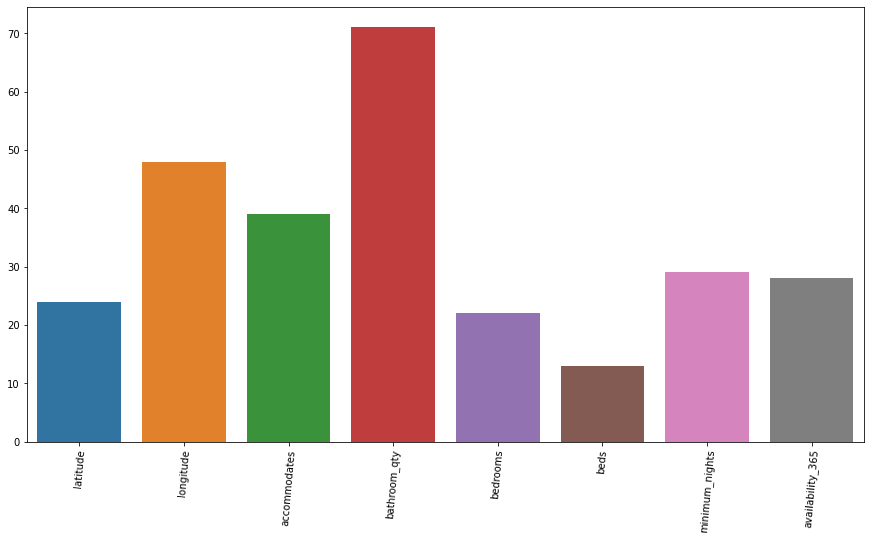

In [27]:
important_features = plot_features(feat_df, 10)

### Predictions

In [28]:
'''Given a Listing ID this function will predict the value with our new model'''
def predict_price(listing_id):
    
    prediction_df = master_df.replace(np.log(0), 0)
    prediction_df = prediction_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    prediction_df = prediction_df.loc[prediction_df['id'] == listing_id]

    X = prediction_df.drop(columns = ['price', 'id'])

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_scaled = scaler.transform(X)
    
    print('Listing URL', listingsGZ_df['listing_url'].loc[listingsGZ_df['id'] == listing_id].reset_index(drop=True)[0])
    print('Actual Price:', master_df['price'].loc[master_df['id'] == listing_id].reset_index(drop=True)[0])
    print('Predicted Price:', round(estimator_xgb.predict(X_scaled)[0]) )

In [29]:
predict_price(51969004)

Listing URL https://www.airbnb.com/rooms/51969004
Actual Price: 1045.0
Predicted Price: 765


<ipython-input-28-36a0f986aaad>:4: RuntimeWarning: divide by zero encountered in log
  prediction_df = master_df.replace(np.log(0), 0)


In [30]:
y_pred = estimator_xgb.predict(X_test_scaled)

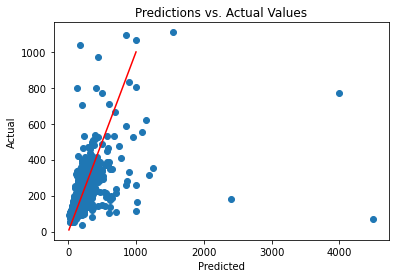

In [31]:
plt.scatter(y_test, y_pred)
plt.plot([x for x in range(9,1000)],[x for x in range(9,1000)], color='red')
plt.title("Predictions vs. Actual Values")
plt.xlabel("Predicted")
plt.ylabel("Actual");

# Conclusion

#### Model and Use Case
    The Model I built uses LGBMRegressor() and the inputs are a select features a common property owner would know/can obtain. So, property owners are able to use this model to estimate the daily price of renting their property with airbnb. This could be used by a prospective investor interested in learning how much money a property could generate if they were to rent it out with airbnb.
#### Future Iterations of the Model
    More effort into feature engineering varaibles that could be created by inputs that are easy for a user to enter. For example, having the address of the airbnb would allow important features such as latitude and longitude be created using the google maps API. Additionally, features could be engineered such as distance from Denver National Airport or common tourist attractions.